In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import cv2

Using TensorFlow backend.
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/swchoi1994/opt/anacond

In [2]:
x_ray_data = pd.read_csv('added_paths_AP.csv')
x_ray_data.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
5,00000032_003.png,No Finding,3,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
6,00000032_004.png,Edema,4,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
7,00000032_004.png,Effusion,4,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
8,00000032_004.png,Cardiomegaly,4,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
9,00000032_005.png,No Finding,5,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...


In [3]:
num_obs = len(x_ray_data)
print('Number of observations:',num_obs)

Number of observations: 5637


In [4]:
from keras.models import load_model
from sklearn.model_selection import train_test_split

In [5]:
import pandas as pd
import numpy as np

#x_ray_data['split'] = np.random.randn(x_ray_data.shape[0], 1)

train, validate, test = np.split(x_ray_data.sample(frac=1), [int(.6*len(x_ray_data)), int(.8*len(x_ray_data))])
print(train)
train.to_csv("train_df.csv", sep=',')
validate.to_csv("valid_df.csv",sep=',')
test.to_csv("test_df.csv",sep=',')
print(validate)
print(test)

           Image Index      Finding Labels  Follow-up #  Patient ID  \
4101  00020999_002.png               Edema            2       20999   
573   00002072_010.png        Infiltration           10        2072   
32    00000032_021.png        Cardiomegaly           21          32   
2873  00013992_001.png          No Finding            1       13992   
3498  00018390_008.png          No Finding            8       18390   
...                ...                 ...          ...         ...   
2391  00010698_000.png       Consolidation            0       10698   
2172  00009846_000.png          No Finding            0        9846   
431   00001836_066.png          No Finding           66        1836   
3740  00019946_002.png          No Finding            2       19946   
680   00003005_021.png  Pleural_Thickening           21        3005   

      Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
4101           70              F            AP                 2500

In [19]:
#labels = ['Cardiomegaly', 
          #'Emphysema', 
          #'Effusion', 
          #'Hernia', 
          #'Infiltration', 
          #'Mass', 
          #'Nodule', 
          #'Atelectasis',
          #'Pneumothorax',
          #'Pleural_Thickening', 
          #'Pneumonia', 
          #'Fibrosis', 
          #'Edema', 
          #'Consolidation']

In [20]:
from sklearn.model_selection import train_test_split

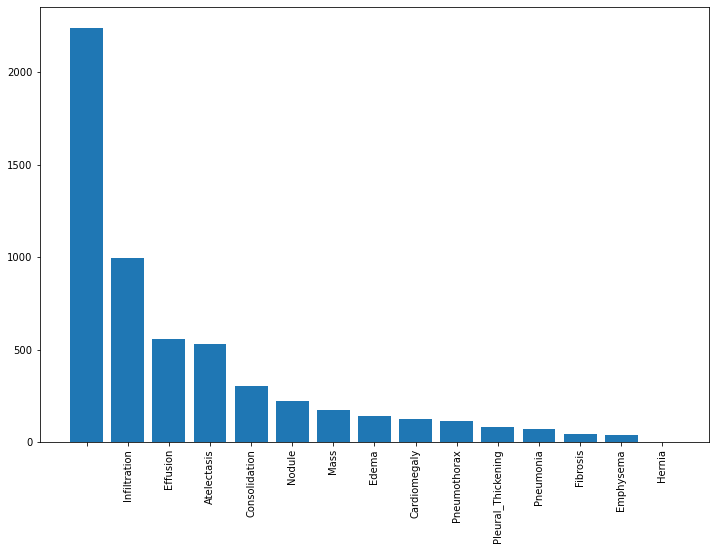

In [21]:
label_counts = x_ray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [22]:
x_ray_data['Finding Labels'] = x_ray_data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*x_ray_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        x_ray_data[c_label] = x_ray_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
#x_ray_data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [23]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if x_ray_data[c_label].sum()>MIN_CASES]

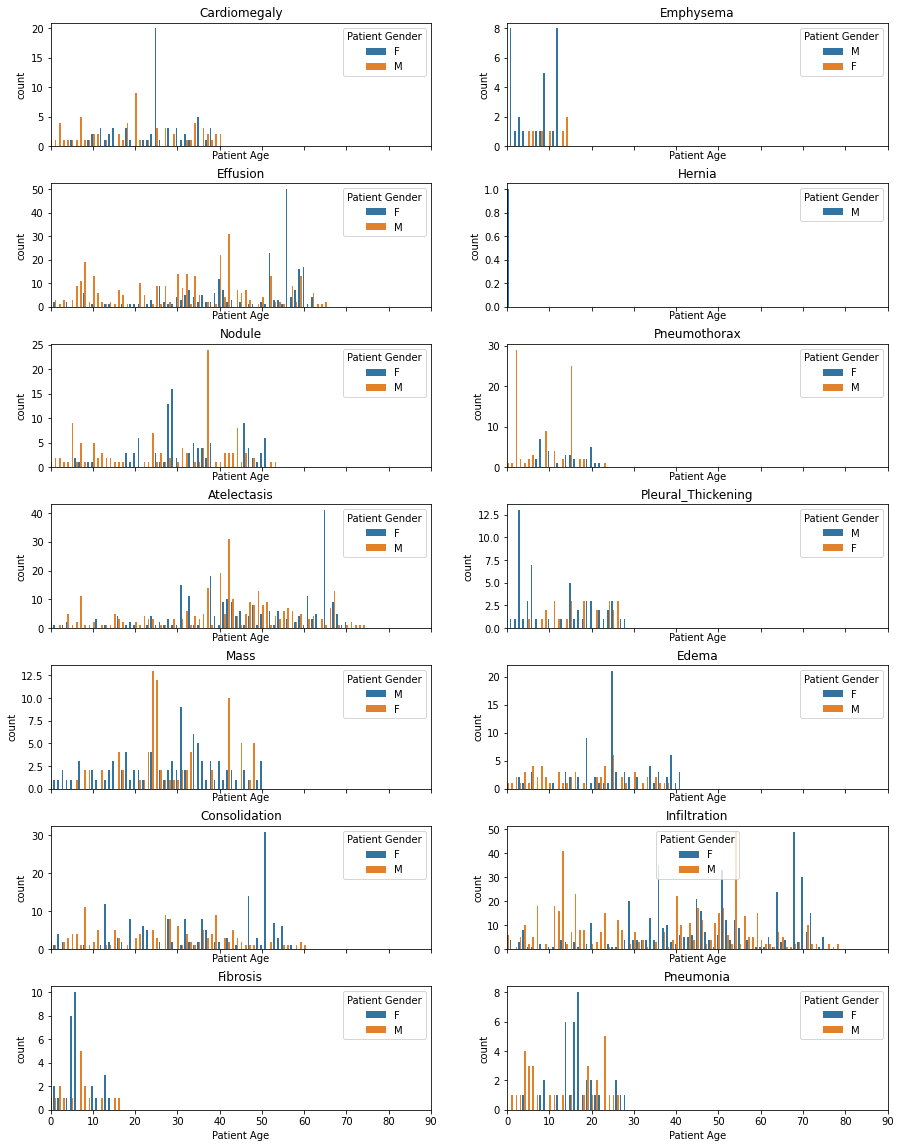

In [24]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = x_ray_data[x_ray_data['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

In [25]:
#x_ray_data['disease_vec'] = x_ray_data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
train_df = pd.read_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/train_df.csv")
valid_df = pd.read_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/valid_df.csv")

test_df = pd.read_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/test_df.csv")

In [26]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [27]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [32]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image Index", 
        y_col="Finding Labels", 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [33]:
IMAGE_DIR = "/Users/swchoi1994/Documents/DL_Projects/NIH/X_Rays/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Index", "Finding Labels")
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image Index", "Finding Labels")

getting train generator...
Found 3382 validated image filenames.
getting train and valid generators...
Found 3382 validated image filenames.
Found 1127 validated image filenames.
Found 1128 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


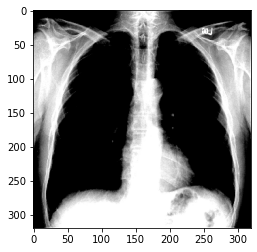

In [34]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

In [73]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(pos_weights):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
            #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [90]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of labels (columns)
    N = x_ray_data["Finding Labels"].count
    
    
    positive_frequencies = np.sum(labels, axis = 0) / labels.shape[0]
    negative_frequencies = 1- positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos


TypeError: unsupported operand type(s) for /: 'str' and 'method'

In [87]:

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights


In [88]:
# create the base pre-trained model
base_model = DenseNet121(weights='/Users/swchoi1994/Documents/DL_Projects/NIH/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(15, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

AttributeError: 'float' object has no attribute 'dtype'

In [ ]:
model.load_weights("/Users/swchoi1994/Documents/DL_Projects/NIH/pretrained_model.h5")

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [ ]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image Index"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
df = pd.read_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/train_df.csv")
IMAGE_DIR = "/Users/swchoi1994/Documents/DL_Projects/NIH/X_Rays/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)
compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)
compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)


In [ ]:
compute_gradcam(model, 'SWCHOI_001.png', IMAGE_DIR, df, labels, labels_to_show)

# Reference:

AI in Medicine. Part 1: Medical Diagnosis by Coursera

